# Análisis de publicaciones sobre sostenibilidad 🌱  
En este cuaderno trabajaremos con el dataset **sustainability_social_media_posts.csv**, que contiene publicaciones de redes sociales relacionadas con la sostenibilidad.  

El objetivo es:  
1. Preprocesar los textos usando técnicas de **NLP** (Procesamiento de Lenguaje Natural).  
2. Vectorizar los textos con **TF-IDF**.  
3. Construir y entrenar una **red neuronal** para clasificar el sentimiento de las publicaciones (Positivo, Negativo, Neutro).  


## Instalación e Importación de Librerías
Primero instalamos y cargamos las librerías necesarias para NLP, machine learning y deep learning.

In [2]:
!pip install nltk tensorflow scikit-learn matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Cargar el Dataset
Subimos el archivo **sustainability_social_media_posts.csv** y lo cargamos en un DataFrame de Pandas.  
Exploramos sus dimensiones y mostramos las primeras filas.



In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("sustainability_social_media_posts.csv")
print("Dimensiones del dataset:", df.shape)
df.head()


Saving sustainability_social_media_posts.csv to sustainability_social_media_posts (1).csv
Dimensiones del dataset: (3144, 15)


,post_id,user_id,username,post_date,platform,hashtag,post_text,engagement_likes,engagement_shares,engagement_comments,user_followers,user_location,post_sentiment,climate_topic,call_to_action
0,1,7dc6bf9d-15aa-42e3-87a7-42fe06eff6a7,earthloverstrike10649,2024-10-17,Facebook,#gogreen,Climate justice engages global citizens with c...,8318,1801,1362,821449,"Tokyo, Japan",Positive,Waste Reduction,Insulate your home effectively.
1,2,d5255db8-8737-4b4c-90cd-d46beb7b3b14,ecowarriorchain6514,2024-08-22,LinkedIn,#climatefinance,Green technology should be embraced through in...,8768,1079,220,1620578,"Stockholm, Sweden",Negative,Water Management,Choose clean power sources.
2,3,8d6fdb18-331f-4f55-b27c-4570378f012b,healthydominator9150,2024-09-01,LinkedIn,#climatehope2025,Clean energy builds a greener future in our da...,8683,1581,202,1405736,"Brussels, Belgium",Neutral,Sustainable Tourism,Switch to refillable containers.
3,4,811a690f-dd65-42ad-b1b3-80d57834945a,zeroemissionpulse6238,2024-09-28,X,#climatechange,Geothermal energy provides renewable heating s...,8026,266,818,1863665,"Singapore, Singapore",Positive,Eco-friendly Materials,Promote sustainable agriculture.
4,5,a8c1bf64-b160-4414-9979-1cf935ffb176,cleanseenergy2267,2025-03-13,X,#greenrevolution,Energy storage systems enable renewable integr...,2305,1194,215,254799,"Edinburgh, UK",Neutral,Energy Storage,Organize climate talks at schools.


## Exploración Inicial
Analizamos la distribución de sentimientos en el dataset para ver el balance de clases.


post_sentiment
Positive    1282
Neutral      941
Negative     921
Name: count, dtype: int64


/tmp/ipython-input-3984579060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="post_sentiment", palette="Set2")


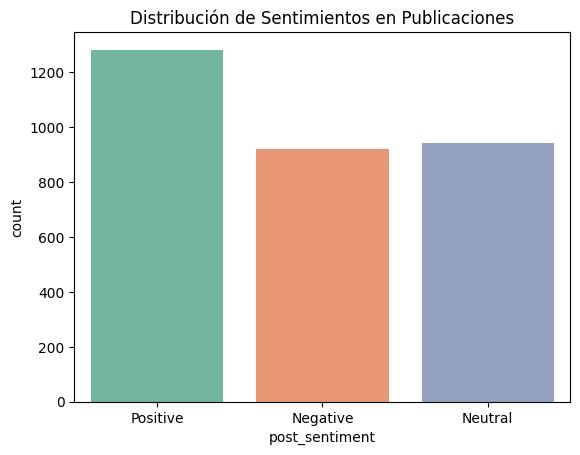

In [4]:
print(df["post_sentiment"].value_counts())

sns.countplot(data=df, x="post_sentiment", palette="Set2")
plt.title("Distribución de Sentimientos en Publicaciones")
plt.show()


## Preprocesamiento NLP
Aplicamos los siguientes pasos al texto:
- Convertir a minúsculas  
- Eliminar URLs y puntuación  
- Eliminar *stopwords* (palabras vacías)  
- Lematización para reducir las palabras a su forma base  


In [5]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["post_text"].apply(limpiar_texto)
df[["post_text", "clean_text"]].head()


,post_text,clean_text
0,Climate justice engages global citizens with c...,climate justice engages global citizen collect...
1,Green technology should be embraced through in...,green technology embraced innovation biodivers...
2,Clean energy builds a greener future in our da...,clean energy build greener future daily life e...
3,Geothermal energy provides renewable heating s...,geothermal energy provides renewable heating s...
4,Energy storage systems enable renewable integr...,energy storage system enable renewable integra...


## Vectorización con TF-IDF
Convertimos los textos preprocesados en vectores numéricos utilizando **TF-IDF**, limitando el vocabulario a 5000 palabras más frecuentes.


In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"]).toarray()


## Preparación de Etiquetas
Codificamos los sentimientos como valores numéricos:
- 0 = Negativo
- 1 = Neutral
- 2 = Positivo


In [7]:
encoder = LabelEncoder()
y = encoder.fit_transform(df["post_sentiment"])
y_cat = to_categorical(y)


## División en Entrenamiento y Prueba
Separamos el dataset en 80% entrenamiento y 20% prueba.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (2515, 481)
Tamaño de prueba: (629, 481)


## Construcción del Modelo
Creamos una red neuronal sencilla en Keras con:
- Una capa oculta de 128 neuronas (ReLU)
- Una capa oculta de 64 neuronas (ReLU)
- Una capa de salida con 3 neuronas (softmax) para clasificación multiclase


In [9]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entrenamiento
Entrenamos la red neuronal durante 10 épocas y validamos con el conjunto de prueba.


In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3482 - loss: 1.0980 - val_accuracy: 0.4086 - val_loss: 1.0887
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4260 - loss: 1.0742 - val_accuracy: 0.4086 - val_loss: 1.0883
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4221 - loss: 1.0627 - val_accuracy: 0.4038 - val_loss: 1.0937
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4770 - loss: 1.0314 - val_accuracy: 0.4022 - val_loss: 1.1055
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5118 - loss: 0.9998 - val_accuracy: 0.3577 - val_loss: 1.1222
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5361 - loss: 0.9706 - val_accuracy: 0.3911 - val_loss: 1.1430
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5620 - loss: 0.9408 - val_accuracy: 0.4006 - val_loss: 1.1685
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6286 - loss: 0.8692 - val_accuracy: 0.3784 - val_loss:

## Evaluación del Modelo
Calculamos la precisión en el conjunto de prueba, mostramos el reporte de clasificación y graficamos la matriz de confusión.


Accuracy en test: 0.3704
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Reporte de Clasificación:

              precision    recall  f1-score   support

    Negative       0.29      0.17      0.22       184
     Neutral       0.29      0.28      0.28       188
    Positive       0.44      0.58      0.50       257

    accuracy                           0.37       629
   macro avg       0.34      0.34      0.33       629
weighted avg       0.35      0.37      0.35       629



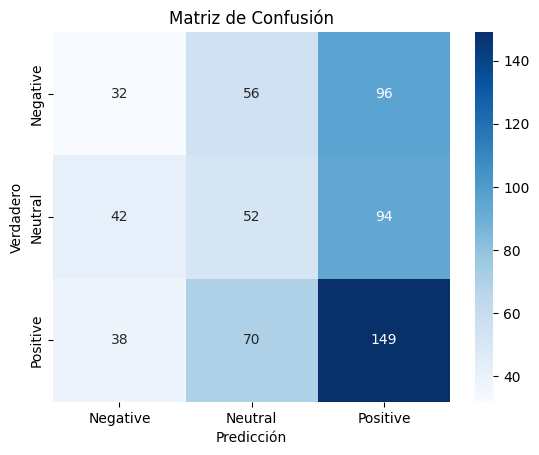

In [11]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy en test: {acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nReporte de Clasificación:\n")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()


## Curvas de Entrenamiento
Visualizamos la evolución del accuracy y la pérdida durante las épocas.


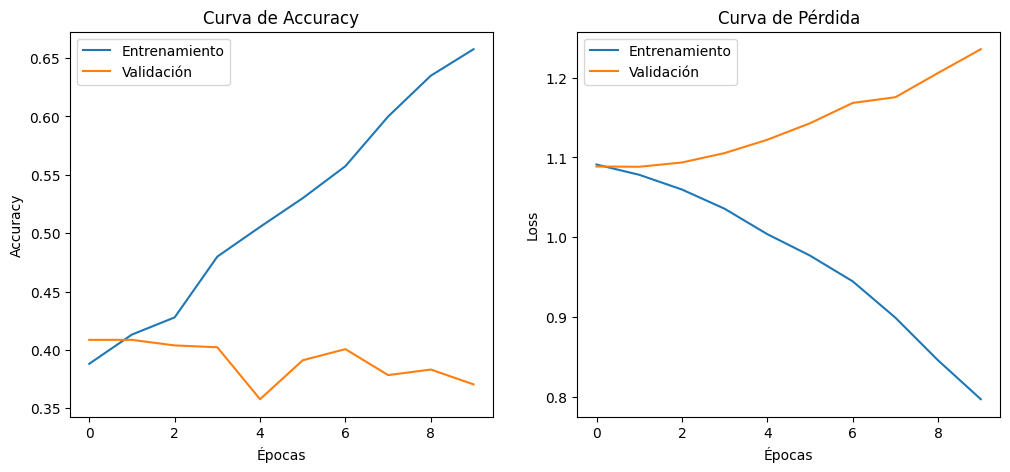

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curva de Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()
